# Model Training on BraTS t2f Brain MRI 

In [1]:
import numpy as np
import nibabel as nib
import glob
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import torch

In [2]:
DATA_DIR_T2W = "D:\MedGAN\Dataset\ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData\TrainingData\input_data_image\\t2w"
GAN_TRAIN_T1 = "D:\MedGAN\Dataset\IXI\T1\\T1\T1_256_Data"

In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [4]:
import os
import cv2
from PIL import Image 

In [5]:
# BraTS parameters
image_dis_size = 128
batch_dis_size = 32
# latent_size = 128
# stats = (0.5, 0.5, 0.5), (0.5,0.5,0.5)
stats_dis = (0.5,), (0.5,)

In [6]:
# IXI Parameters
image_gen_size = 256
batch_gen_size = 32
brain_gen_slice = 155
stats_gen = (0.5,), (0.5,)

## BraTS Data

In [7]:
train_ds = ImageFolder(
    DATA_DIR_T2W, 
    transform=T.Compose([
        T.Resize(image_dis_size),
        T.CenterCrop(image_dis_size),
        T.Grayscale(num_output_channels=1),
        T.ToTensor(),
        T.Normalize(*stats_dis)
    ]))

train_dl = DataLoader(
    train_ds, batch_dis_size, shuffle=True, 
    num_workers=4, pin_memory=True
)

In [8]:
for img, _ in train_dl:
    print(img.shape)
    print(type(img))
    break


torch.Size([32, 1, 128, 128])
<class 'torch.Tensor'>


In [9]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def denorm(img_tensor):
    return img_tensor * stats_dis[1][0] + stats_dis[0][0]

In [11]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))

def show_batch(dl, nmax=64, model="dis"):
    if model=="dis":
        for images, _ in dl:
            show_images(images, nmax)
            break
    else:
        for images in dl:
            show_images(images,nmax)
        

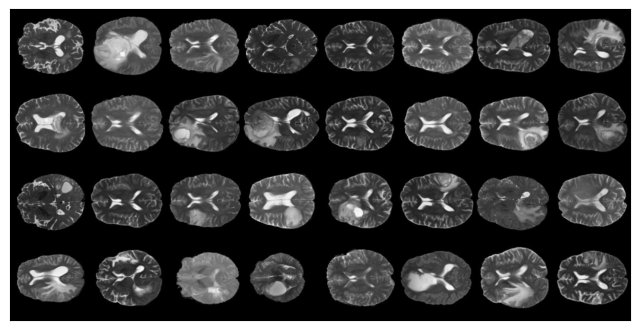

In [12]:
show_batch(train_dl)

## IXI Data

In [13]:

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import numpy as np
import os

class NpyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Directory with .npy files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        print(self.root_dir)
        self.file_list = [f for f in os.listdir(root_dir) if f.endswith(".npy")]
        self.transform = transform

    def __len__(self):
        return len(self.file_list)
    
    def return_file_list(self):
        return self.file_list

    def __getitem__(self, idx):
        file_path = os.path.join(self.root_dir, self.file_list[idx])
        
        # Load the .npy file (NumPy array)
        image = np.load(file_path)
        # print(image.shape)

        if image.ndim == 2:
            image = np.expand_dims(image, axis=0)
            # print(image.shape)

        # # image_torch = torch.from_numpy(image)
        # image = T.ToPILImage()(image)

        if self.transform:
            for transform_func in self.transform:
                image = transform_func(image)

        
        return image


In [14]:
import numpy as np


def normalise(img):
    # Example input image
    img_max = np.max(img)
    img2 = img * img_max # Simulating an MRI image with values up to 745.71

    # Normalize from 0 to 255
    img2_normalized = ((img2 - np.min(img2)) / (np.max(img2) - np.min(img2))) * 255

    # Convert to uint8 (8-bit image)
    img2_normalized = img2_normalized.astype(np.uint8)

    return img2_normalized

In [15]:
transformations = [
    normalise
]

In [16]:
GAN_TRAIN_T1

'D:\\MedGAN\\Dataset\\IXI\\T1\\T1\\T1_256_Data'

In [17]:
gan_train_input = NpyDataset(os.path.join(GAN_TRAIN_T1,"train\Images"), transform=transformations)
gan_val_input = NpyDataset(os.path.join(GAN_TRAIN_T1,"val\Images"), transform=transformations)

D:\MedGAN\Dataset\IXI\T1\T1\T1_256_Data\train\Images
D:\MedGAN\Dataset\IXI\T1\T1\T1_256_Data\val\Images


In [18]:
# Create DataLoader
gan_train_dl = DataLoader(
    gan_train_input, batch_gen_size, shuffle=True
)

In [19]:
# # Example: Get a batch
images = next(iter(gan_train_dl))
print(images.shape) 
print(type(images))

torch.Size([32, 1, 256, 256])
<class 'torch.Tensor'>


In [20]:
for img2 in gan_train_dl:
    print(img2.shape)
    print(type(img2))
    break


torch.Size([32, 1, 256, 256])
<class 'torch.Tensor'>


In [21]:
def get_default_device():
    """Pick GPU if available, else CPU"""

    # for testing return cpu 
    # return torch.device('cpu') 


    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
device = get_default_device()
device

device(type='cuda')

In [23]:
train_dl = DeviceDataLoader(train_dl, device)

In [24]:
import torch.nn as nn

In [25]:
# # Discriminator 1

# discriminator = nn.Sequential(
#     # in: 1 x 128 x 128

#     nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(64),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 64 x 64 x 64

#     nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(128),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 128 x 32 x 32

#     nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(256),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 256 x 16 x 16

#     nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(512),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 512 x 8 x 8

#     nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(1024),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 512 x 4 x 4

#     nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
#     # out: 1 x 1 x 1

#     nn.Flatten(),
#     nn.Sigmoid())

In [26]:
# Discriminator 1

discriminator1 = nn.Sequential(
    # in: 1 x 128 x 128

    nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 128 x 128

    nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 128 x 128

    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 64 x 64

    nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 64 x 64

    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 32 x 32

    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 32 x 32

    nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 8 x 8

    nn.Conv2d(1024, 256, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 4 x 4

    nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [27]:
# D2 Testing

xb = torch.randn(1, 1, 128, 128)

print(xb.shape)

c1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
c2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
c3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False)
c4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
c5 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False)
c6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
c7 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=False)
c8 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False)
c9 = nn.Conv2d(512, 256, kernel_size=3, stride=2, padding=1, bias=False)
c10 = nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False)
c11 = nn.Flatten()
c12 = nn.Sigmoid()

out = c1(xb)

c = [c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12]

for n, layer in enumerate(c):
    out = layer(out)
    print(f"Layer {n+2}: ",out.shape)


print(out)



torch.Size([1, 1, 128, 128])
Layer 2:  torch.Size([1, 64, 128, 128])
Layer 3:  torch.Size([1, 128, 64, 64])
Layer 4:  torch.Size([1, 128, 64, 64])
Layer 5:  torch.Size([1, 256, 32, 32])
Layer 6:  torch.Size([1, 256, 32, 32])
Layer 7:  torch.Size([1, 256, 16, 16])
Layer 8:  torch.Size([1, 512, 8, 8])
Layer 9:  torch.Size([1, 256, 4, 4])
Layer 10:  torch.Size([1, 1, 1, 1])
Layer 11:  torch.Size([1, 1])
Layer 12:  torch.Size([1, 1])
tensor([[0.4984]], grad_fn=<SigmoidBackward0>)


In [28]:
from torchinfo import summary

In [29]:
discriminator1

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  

In [30]:
summary(model = discriminator1, input_size=(1, 1,128,128))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 1]                    --
├─Conv2d: 1-1                            [1, 64, 128, 128]         576
├─BatchNorm2d: 1-2                       [1, 64, 128, 128]         128
├─LeakyReLU: 1-3                         [1, 64, 128, 128]         --
├─Conv2d: 1-4                            [1, 64, 128, 128]         36,864
├─BatchNorm2d: 1-5                       [1, 64, 128, 128]         128
├─LeakyReLU: 1-6                         [1, 64, 128, 128]         --
├─Conv2d: 1-7                            [1, 128, 64, 64]          73,728
├─BatchNorm2d: 1-8                       [1, 128, 64, 64]          256
├─LeakyReLU: 1-9                         [1, 128, 64, 64]          --
├─Conv2d: 1-10                           [1, 128, 64, 64]          147,456
├─BatchNorm2d: 1-11                      [1, 128, 64, 64]          256
├─LeakyReLU: 1-12                        [1, 128, 64, 64]          

In [31]:
discriminator = to_device(discriminator1, device)

In [32]:
# Generator 1

generator = nn.Sequential(
    # in: 1 x 256 x 256

    # Down Sampling 1x128x128 -> 128x4x4
    
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 16 x 128 x 128
    
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 16 x 64 x 64

    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 32 x 32 x 32

    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 16 x 16

    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 8 x 8

    nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 4 x 4

    # Latent matrix : 128 x 4 x 4

    # Up Sampling 128x4x4 -> 1x128x128
    nn.ConvTranspose2d(128, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 1 x 64 x 64
)

In [33]:
# G1 testing 

xb = torch.randn(128, 1, 256, 256)

print(xb.shape)
# Downsampling 
c0 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False)
c1 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1, bias=False)
c2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
c3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False)
c4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False)
c5 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=False)

# Upsampling
c6 = nn.ConvTranspose2d(128, 512, kernel_size=4, stride=2, padding=1, bias=False)
c7 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False)
c75 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
c8 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False)
c85 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
c9 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False)
c10 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False)
c11 = nn.Tanh()


out = c0(xb)
print("Layer 1: ", out.shape)

c = [c1,c2, c3, c4, c5, c6, c7,c75, c8,c85, c9, c10, c11]

for n, layer in enumerate(c):
    out = layer(out)
    print(f"Layer {n+2}: ",out.shape)
    if layer == c5:
        print()



torch.Size([128, 1, 256, 256])
Layer 1:  torch.Size([128, 16, 128, 128])
Layer 2:  torch.Size([128, 16, 64, 64])
Layer 3:  torch.Size([128, 32, 32, 32])
Layer 4:  torch.Size([128, 64, 16, 16])
Layer 5:  torch.Size([128, 128, 8, 8])
Layer 6:  torch.Size([128, 128, 4, 4])

Layer 7:  torch.Size([128, 512, 8, 8])
Layer 8:  torch.Size([128, 256, 16, 16])
Layer 9:  torch.Size([128, 256, 16, 16])
Layer 10:  torch.Size([128, 128, 32, 32])
Layer 11:  torch.Size([128, 128, 32, 32])
Layer 12:  torch.Size([128, 64, 64, 64])
Layer 13:  torch.Size([128, 1, 128, 128])
Layer 14:  torch.Size([128, 1, 128, 128])


In [34]:
summary(model=generator, input_size=(128,1,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [128, 1, 112, 112]        --
├─Conv2d: 1-1                            [128, 16, 128, 128]       144
├─BatchNorm2d: 1-2                       [128, 16, 128, 128]       32
├─LeakyReLU: 1-3                         [128, 16, 128, 128]       --
├─Conv2d: 1-4                            [128, 16, 64, 64]         2,304
├─BatchNorm2d: 1-5                       [128, 16, 64, 64]         32
├─LeakyReLU: 1-6                         [128, 16, 64, 64]         --
├─Conv2d: 1-7                            [128, 32, 32, 32]         4,608
├─BatchNorm2d: 1-8                       [128, 32, 32, 32]         64
├─LeakyReLU: 1-9                         [128, 32, 32, 32]         --
├─Conv2d: 1-10                           [128, 64, 16, 16]         18,432
├─BatchNorm2d: 1-11                      [128, 64, 16, 16]         128
├─LeakyReLU: 1-12                        [128, 64, 16, 16]         --
├─C

In [35]:
import functools
from torch.nn import init

In [36]:
# # Generator 2

# class Unet(nn.Module):

#     def __init__(self,in_dim=1,conv_dim=64,out_dim=1):
#         super(Unet, self).__init__()
#         self.conv1=nn.Sequential(
#             nn.Conv2d(in_dim,conv_dim,kernel_size=3,stride=2,padding=1), #64
#             nn.BatchNorm2d(conv_dim),
#             nn.ReLU(inplace=True)
#         )
#         self.conv2=nn.Sequential(
#             nn.Conv2d(conv_dim,conv_dim*2,kernel_size=3,stride=2,padding=1), #32
#             nn.BatchNorm2d(conv_dim*2),
#             nn.ReLU(inplace=True)
#         )
#         self.conv3 =nn.Sequential(
#             nn.Conv2d(conv_dim*2, conv_dim * 4, kernel_size=3, stride=2, padding=1), #16
#             nn.BatchNorm2d(conv_dim * 4),
#             nn.ReLU(inplace=True)
#         )
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(conv_dim * 4, conv_dim * 8, kernel_size=3, stride=2, padding=1), #8
#             nn.BatchNorm2d(conv_dim * 8),
#             nn.ReLU(inplace=True)
#         )
#         self.deconv1=nn.Sequential(
#             nn.ConvTranspose2d(conv_dim * 8,conv_dim * 8,kernel_size=3,stride=2,padding=1,output_padding=1),
#             nn.BatchNorm2d(conv_dim * 8),
#             nn.ReLU(inplace=True)
#         )
#         self.deconv2=nn.Sequential(
#             nn.ConvTranspose2d(conv_dim * (8+4),conv_dim * 4,kernel_size=3,stride=2,padding=1,output_padding=1),
#             nn.BatchNorm2d(conv_dim * 4),
#             nn.ReLU(inplace=True)
#         )
#         self.deconv3=nn.Sequential(
#             nn.ConvTranspose2d(conv_dim * (4+2),conv_dim * 2,kernel_size=3,stride=2,padding=1,output_padding=1),
#             nn.BatchNorm2d(conv_dim * 2),
#             nn.ReLU(inplace=True)
#         )
#         self.deconv4=nn.Sequential(
#             nn.ConvTranspose2d(conv_dim * (2+1),out_dim ,kernel_size=3,stride=2,padding=1,output_padding=1),
#             nn.Sigmoid(),
#         )
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, a=0)
#                 if hasattr(m, 'bias') and m.bias is not None:
#                     nn.init.constant_(m.bias.data, 0.0)
#             if isinstance(m,nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

                
#     def forward(self, x):
#         x1=self.conv1(x)
#         x2=self.conv2(x1)
#         x3=self.conv3(x2)
#         x4=self.conv4(x3)
#         out=self.deconv1(x4)
#         x3=torch.cat([x3,out],dim=1)
#         out=self.deconv2(x3)
#         x2 = torch.cat([x2, out], dim=1)
#         out=self.deconv3(x2)
#         x1=torch.cat([x1,out],dim=1)
#         out=self.deconv4(x1)
#         return out

In [37]:
# x = torch.rand((1, 1, 128, 128))
# unet=Unet()
# y=unet(x)
# print(y.shape)

In [38]:
# summary(model=unet, input_size=(1,1,128,128))

In [39]:
# Loss function
adversarial_loss = nn.BCELoss()

In [40]:
# trial_image = torch.randn(1, latent_size, 1,1)
# print(trial_image.shape)
# # print(trial_image)


In [41]:
for img2 in gan_train_dl:
    print(img2.shape)
    print(type(img2))
    break


torch.Size([32, 1, 256, 256])
<class 'torch.Tensor'>


In [42]:
device

device(type='cuda')

In [43]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

# Assuming denorm is defined somewhere
def denorm(images):
    # Example denormalization (if normalized to [0, 1] range)
    return images * 0.5 + 0.5  # This assumes images were normalized in the range [-1, 1]

def show_gen_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])

    # Make sure images are detached, moved to CPU and sliced to a maximum of nmax images
    images = images.cpu().detach()[:nmax]
    
    # Denormalize and show the images
    ax.imshow(make_grid(denorm(images), nrow=8).permute(1, 2, 0))

def show_gen_batch(dl, nmax=64, model="dis"):
    if model == "dis":
        for images, _ in dl:  # Assuming you get (images, labels) from the dataloader
            show_gen_images(images, nmax)
            break  # Only show the first batch
    else:
        for images in dl:
            show_gen_images(images, nmax)
            break  # Only show the first batch


<class 'torch.Tensor'>
torch.Size([32, 1, 112, 112])


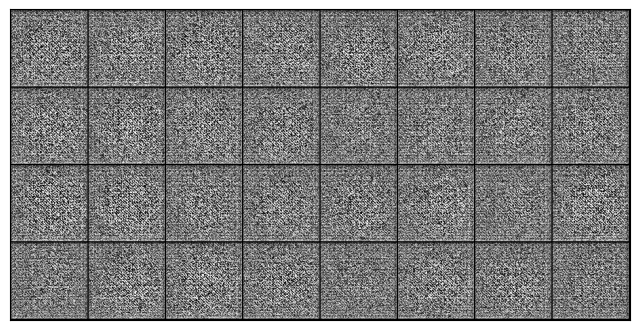

In [44]:

xb = next(iter(gan_train_dl))
xb = to_device(xb, device)
xb = xb.float()
fake_images = generator(xb)
print(type(fake_images))
print(fake_images.shape)
show_gen_images(fake_images)

In [45]:
# Initialize generator and discriminator

discriminator = to_device(discriminator, device)
generator = to_device(generator, device)

In [46]:
import torch.nn.functional as F

In [47]:
# def gradient_penalty(discriminator, real_images, fake_images, lambda_gp=10):
#     """
#     Compute gradient penalty for WGAN-GP.
    
#     Args:
#     - discriminator: The discriminator model.
#     - real_images: A batch of real images.
#     - fake_images: A batch of generated (fake) images.
#     - lambda_gp: Weight for gradient penalty.
    
#     Returns:
#     - Gradient penalty.
#     """
#     batch_size = real_images.size(0)
#     epsilon = torch.rand(batch_size, 1, 1, 1, device=real_images.device, requires_grad=True)
#     interpolated_images = epsilon * real_images + (1 - epsilon) * fake_images
#     interpolated_scores = discriminator(interpolated_images)
    
#     gradients = torch.autograd.grad(
#         outputs=interpolated_scores,
#         inputs=interpolated_images,
#         grad_outputs=torch.ones_like(interpolated_scores),
#         create_graph=True,
#         retain_graph=True
#     )[0]
    
#     gradients = gradients.view(batch_size, -1)
#     gradient_norm = gradients.norm(2, dim=1)
#     penalty = lambda_gp * ((gradient_norm - 1) ** 2).mean()
#     return penalty

In [48]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    # real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_loss = adversarial_loss(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = next(iter(gan_train_dl))
    latent = latent.cuda().float()
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    # fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_loss = adversarial_loss(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = (real_loss + fake_loss)/2
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [49]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = next(iter(gan_train_dl))
    latent = latent.cuda().float()
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_gen_size, 1, device=device)
    # loss = F.binary_cross_entropy(preds, targets)
    loss = adversarial_loss(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [50]:
from torchvision.utils import save_image
import os

In [56]:
device

device(type='cuda')

In [57]:
sample_dir = 'generated2'
os.makedirs(sample_dir, exist_ok=True)

In [58]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [59]:
fixed_latent = next(iter(gan_train_dl))
fixed_latent = fixed_latent.cuda().float()
fixed_latent = to_device(fixed_latent, "cpu")

In [60]:
save_samples(0, fixed_latent)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999999..1.0].


Saving generated-images-0000.png


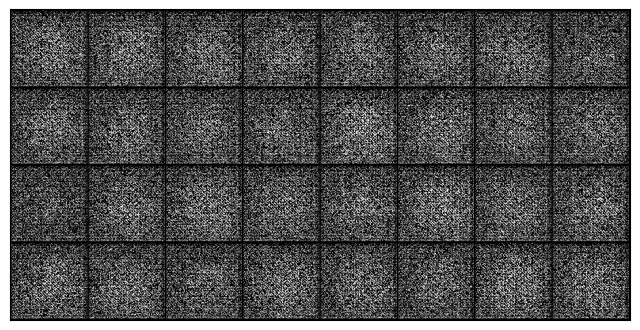

In [61]:
def save_gen_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)  # Generate fake images
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

# Assuming `gan_train_dl` is your DataLoader:
fixed_latent = next(iter(gan_train_dl))  # Get a batch of latent vectors
fixed_latent = fixed_latent.float()  # Convert to FloatTensor
fixed_latent = to_device(fixed_latent, "cuda")  # Move to the device (GPU if available)

save_gen_samples(0, fixed_latent)  # Save the generated images


In [62]:
from tqdm.notebook import tqdm

In [63]:
import csv
# loss_g: 3.5279, loss_d: 0.6153, real_score: 0.7169, fake_score: 0.1814
titles = ["epoch", "loss_g", "loss_d", "real_score", "fake_score"]

with open('record3.csv', 'w') as cf:
    csvwriter = csv.writer(cf)
    # writing the fields
    csvwriter.writerow(titles)
    # writing the data rows
cf.close()


In [64]:
def record_data(data, file='record3.csv'):

    with open(file, 'a') as cf:
        writer_object = csv.writer(cf)
        writer_object.writerow(data)
 
    # Close the file object
    cf.close()

In [65]:
torch.cuda.empty_cache()

In [66]:
def fit(epochs, lr, start_index=1):
    # torch.mps.empty_cache()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        if (epoch + start_index) % 25 == 0:
            save_samples(epoch+start_index, fixed_latent, show=False)

            # Save the model checkpoints 
            torch.save(generator.state_dict(), 'G'+str(start_index)+'.pth')
            torch.save(discriminator.state_dict(), 'D'+str(start_index)+'.pth')
        
        record_data([epoch+1, loss_g, loss_d, real_score, fake_score])
    
    return losses_g, losses_d, real_scores, fake_scores



In [69]:
lr = 0.0001
epochs = 1000

In [ ]:
# training
history = fit(epochs, lr)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1/1000], loss_g: 11.9217, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [2/1000], loss_g: 11.9411, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [3/1000], loss_g: 12.1459, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [4/1000], loss_g: 12.8188, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [5/1000], loss_g: 12.9326, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [6/1000], loss_g: 13.0619, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [7/1000], loss_g: 13.1336, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [8/1000], loss_g: 13.2952, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [9/1000], loss_g: 13.7736, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [10/1000], loss_g: 13.9271, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [11/1000], loss_g: 14.1351, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [12/1000], loss_g: 14.4539, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [13/1000], loss_g: 14.3689, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [14/1000], loss_g: 14.4395, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [15/1000], loss_g: 14.2304, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [16/1000], loss_g: 14.8410, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [17/1000], loss_g: 14.7835, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [18/1000], loss_g: 14.9064, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G2.pth')
torch.save(discriminator.state_dict(), 'D2.pth')

In [ ]:
from IPython.display import Image

In [ ]:
Image('./generated2/generated-images-0500.png')

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

In [ ]:
real_score

In [ ]:
plt.plot(real_scores, '.')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')

# Performance Evaluation

In [ ]:
import numpy as np

In [ ]:
model_path = "G2.pth"

In [ ]:
generator.load_state_dict(torch.load(model_path, weights_only=True))

In [ ]:
for img, _ in train_dl:
    print(img.shape)
    print(type(img))
    break

brain_no = np.random.randn(128)
original = img[brain_no]

In [ ]:
# xb = torch.randn(1, latent_size, 1, 1)
# fake_images = generator(xb)
# print(fake_images.shape)
# show_images(fake_images)

In [ ]:
# latent_vectors = torch.randn(batch_size, latent_size,1,1)  
# fake_images = generator(latent_vectors) 
# show_images(fake_images)

In [ ]:
# PSNR

from math import log10, sqrt 

import numpy as np 

def PSNR(original, compressed): 
	mse = np.mean((original - compressed) ** 2) 
	if(mse == 0): # MSE is zero means no noise is present in the signal . 
				# Therefore PSNR have no importance. 
		return 100
	max_pixel = 255.0
	psnr = 20 * log10(max_pixel / sqrt(mse)) 
	return psnr 

In [ ]:
import torch
import numpy as np
from skimage.metrics import structural_similarity as ssim

def calculate_psnr_torch(image1, image2, max_pixel_value=1.0):
    mse = torch.mean((image1 - image2) ** 2).item()
    if mse == 0:
        return float('inf')  # Identical images
    psnr = 20 * torch.log10(torch.tensor(max_pixel_value) / torch.sqrt(torch.tensor(mse)))
    return psnr.item()


def calculate_ssim_torch(image1, image2):
    # Ensure both images have the same shape
    if image1.shape != image2.shape:
        raise ValueError(f"Image shapes must match. Got {image1.shape} and {image2.shape}")

    # Convert PyTorch tensors to NumPy arrays for SSIM calculation
    image1_np = image1.squeeze().detach().cpu().numpy()
    image2_np = image2.squeeze().detach().cpu().numpy()

    return ssim(image1_np, image2_np, data_range=image2_np.max() - image2_np.min())


# Example Usage
if __name__ == "__main__":
    # Example tensors (normalized to [0, 1])
    
    psnr_list = []
    ssim_list = []

    for bt in range(batch_size):
        xb = torch.randn(1, latent_size, 1, 1)
        fake_images = generator(xb)

        
        brain_no = np.random.randn(128)
        original = img[bt].unsqueeze(1)

        psnr_value = calculate_psnr_torch(original, fake_images)
        ssim_value = calculate_ssim_torch(original, fake_images)

        psnr_list.append(psnr_value)
        ssim_list.append(ssim_value)


    print(max(psnr_list), min(psnr_list), np.mean(psnr_list))
    print(max(ssim_list), min(ssim_list), np.mean(ssim_list))


In [ ]:
latent_vectors = torch.randn(batch_size, latent_size, 1,1)  
fake_images = generator(latent_vectors) 
fake_images.shape

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import inception_v3
from torchvision import transforms
from scipy.linalg import sqrtm
import numpy as np


def calculate_fid(real_images, fake_images, device="cpu"):

    # Load pretrained InceptionV3 model
    inception = inception_v3(pretrained=True, transform_input=False).to(device)
    inception.fc = nn.Identity()  # Remove the final classification layer
    inception.eval()

    # Preprocessing function for grayscale to RGB
    preprocess = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Expand grayscale images to 3 channels
    def convert_to_rgb(images):
        return images.repeat(1, 3, 1, 1)  

    # Apply preprocessing and extract features
    def extract_features(images):
        images = convert_to_rgb(images) # Convert to 3 channels
        images = preprocess(images)  # Normalize and resize
        with torch.no_grad():
            features = inception(images.to(device)).cpu().numpy()
        return features

    # Extract features for real and fake images
    real_features = extract_features(real_images)
    fake_features = extract_features(fake_images)

    # Calculate the mean and covariance of the features
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)

    # Compute the Fréchet distance
    diff = mu_real - mu_fake
    covmean, _ = sqrtm(sigma_real @ sigma_fake, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid


if __name__ == "__main__":
    # Example grayscale tensors of shape (N, 1, H, W)
    real_images = img  # Real images

    latent_vectors = torch.randn(batch_size, latent_size,1,1)  
    fake_images = generator(latent_vectors) 

    device = device
    fid_score = calculate_fid(real_images, fake_images, device=device)
    print("FID Score:", fid_score)
